# Phishing Websites Detection

AI for Cybersecurity (931II)  
M. Sc. Cybersecurity  
Università di Pisa  
Paolo Bernardi (660944)

## The Dataset

- Phishing Websites Features
- Mohammad, R. and McCluskey, L. (2015, University of Huddersfield)
- UCI Machine Learning Repository https://doi.org/10.24432/C51W2X

## STEP 0: Goal definition

The goal is to be able to classify phishing/legitimate websites (binary classification) from a set of server-side and URL features.

Check-list after data exploration:
1. Is the dataset size enough for my activity? If not, I may need to add datasets / change datasets
2. Is the dataset is balanced? If not, I may need to do some re-balancing
3. Which kind of pre-processing do I aspect to use?
4. Which kind of models? How will I compare them?

In [89]:
from datetime import datetime

start_time = datetime.now()

import os

import numpy as np
import pandas as pd
from scipy.io.arff import loadarff

import sklearn
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score,recall_score, accuracy_score, make_scorer, f1_score
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from scipy.stats import wilcoxon

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 5)
import plotly.express as px
import seaborn as sn

import missingno as msno

from IPython.display import display, HTML

import joblib

def full_value_counts(col):
    counts = col.value_counts()
    percs = col.value_counts(normalize=True)
    return pd.concat([counts, percs], axis=1, keys=['count', 'percentage'])

DROP_DUPLICATES = False
#FEATURE_SELECTION = 'LinearSVC'
FEATURE_SELECTION = 'VarianceThreshold'

%matplotlib inline

## STEP 1: Data Acquisition

### File format

The dataset is stored in [ARFF](https://waikato.github.io/weka-wiki/formats_and_processing/arff_stable/) files.

The Attribute-Relation File Format (ARFF) consists of ASCII data with a list of instances sharing a set of attributes whose type is described in the file header.

### Attribute format

The dataset is fully composed by nominal attributes: 30 websites features and 1 classification (1: phishing, -1: not phishing).

Each attribute category is represented as a number ({1, -1} or {1, 0, -1}) and in the whole dataset the following meaning holds:
  - 1 means that the feature is present
  - -1 means that the feature is not present
  - 0 means that it cannot be clearly stated whether or not the specified feature is present

To make the attribute meaning explicit I've decided to map them to strings that describe their explicit meaning.

In [90]:
# Load the dataset from disk
raw_data = loadarff(os.path.join('dataset', 'Training Dataset.arff'))
raw_df = pd.DataFrame(raw_data[0])

# Map the category values to a more evocative representation
#category_map = {b'-1': 0, b'0': 1, b'1': 2}
#category_map = {b'-1': 0, b'0': 0.5, b'1': 1}
for c in raw_df.columns:
    raw_df[c] = raw_df[c].apply(int)#map(category_map)

### Column names

Finally, to make data visualizations more compact, I've decided to rename the feature columns from their explicit name to Xn, with n going from 1 to 30. I've also chosen to rename the **Result** column to **Phishing**, to make its meaning more explicit. Please note that the results can be still easily interpreted by mapping back the X-based names to their original ones.

In [91]:
# Shorter names for compact display
duplicates_df = raw_df.rename(columns={
    "having_IP_Address": "X1",
    "URL_Length": "X2",
    "Shortining_Service": "X3",
    "having_At_Symbol": "X4",
    "double_slash_redirecting": "X5",
    "Prefix_Suffix": "X6",
    "having_Sub_Domain": "X7",
    "SSLfinal_State": "X8",
    "Domain_registeration_length": "X9",
    "Favicon": "X10",
    "port": "X11",
    "HTTPS_token": "X12",
    "Request_URL": "X13",
    'URL_of_Anchor': 'X14',
    'Links_in_tags': 'X15',
    'SFH': 'X16',
    'Submitting_to_email': 'X17',
    'Abnormal_URL': 'X18',
    'Redirect': 'X19',
    'on_mouseover': 'X20',
    'RightClick': 'X21',
    'popUpWidnow': 'X22',
    'Iframe': 'X23',
    'age_of_domain': 'X24',
    'DNSRecord': 'X25',
    'web_traffic': 'X26',
    'Page_Rank': 'X27',
    'Google_Index': 'X28',
    'Links_pointing_to_page': 'X29',
    'Statistical_report': 'X30',
    'Result': 'Phishing',
})

duplicates_df

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X22,X23,X24,X25,X26,X27,X28,X29,X30,Phishing
0,-1,1,1,1,-1,-1,-1,-1,-1,1,...,1,1,-1,-1,-1,-1,1,1,-1,-1
1,1,1,1,1,1,-1,0,1,-1,1,...,1,1,-1,-1,0,-1,1,1,1,-1
2,1,0,1,1,1,-1,-1,-1,-1,1,...,1,1,1,-1,1,-1,1,0,-1,-1
3,1,0,1,1,1,-1,-1,-1,1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
4,1,0,-1,1,1,-1,1,1,-1,1,...,-1,1,-1,-1,0,-1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11050,1,-1,1,-1,1,1,1,1,-1,-1,...,-1,-1,1,1,-1,-1,1,1,1,1
11051,-1,1,1,-1,-1,-1,1,-1,-1,-1,...,-1,1,1,1,1,1,1,-1,1,-1
11052,1,-1,1,1,1,-1,1,-1,-1,1,...,1,1,1,1,1,-1,1,0,1,-1
11053,-1,-1,1,1,1,-1,-1,-1,1,-1,...,-1,1,1,1,1,-1,1,1,1,-1


## STEP 2: data exploration

In [92]:
duplicates_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11055 entries, 0 to 11054
Data columns (total 31 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   X1        11055 non-null  int64
 1   X2        11055 non-null  int64
 2   X3        11055 non-null  int64
 3   X4        11055 non-null  int64
 4   X5        11055 non-null  int64
 5   X6        11055 non-null  int64
 6   X7        11055 non-null  int64
 7   X8        11055 non-null  int64
 8   X9        11055 non-null  int64
 9   X10       11055 non-null  int64
 10  X11       11055 non-null  int64
 11  X12       11055 non-null  int64
 12  X13       11055 non-null  int64
 13  X14       11055 non-null  int64
 14  X15       11055 non-null  int64
 15  X16       11055 non-null  int64
 16  X17       11055 non-null  int64
 17  X18       11055 non-null  int64
 18  X19       11055 non-null  int64
 19  X20       11055 non-null  int64
 20  X21       11055 non-null  int64
 21  X22       11055 non-null  int64
 22

In [93]:
duplicates_df.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X22,X23,X24,X25,X26,X27,X28,X29,X30,Phishing
count,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,...,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000
mean,0.313795,-0.633198,0.738761,0.700588,0.741474,-0.734962,0.063953,0.250927,-0.336771,0.628584,...,0.613388,0.816915,0.061239,0.377114,0.287291,-0.483673,0.721574,0.344007,0.719584,0.113885
std,0.949534,0.766095,0.673998,0.713598,0.671011,0.678139,0.817518,0.911892,0.941629,0.777777,...,0.789818,0.576784,0.998168,0.926209,0.827733,0.875289,0.692369,0.569944,0.694437,0.993539
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,...,1.000000,1.000000,-1.000000,-1.000000,0.000000,-1.000000,1.000000,0.000000,1.000000,-1.000000
50%,1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,1.000000,-1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,0.000000,1.000000,1.000000
75%,1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [94]:
duplicates_value_counts = full_value_counts(duplicates_df.Phishing)
duplicates_value_counts

,count,percentage
Phishing,,
1,6157,0.556943
-1,4898,0.443057


<Axes: ylabel='count'>

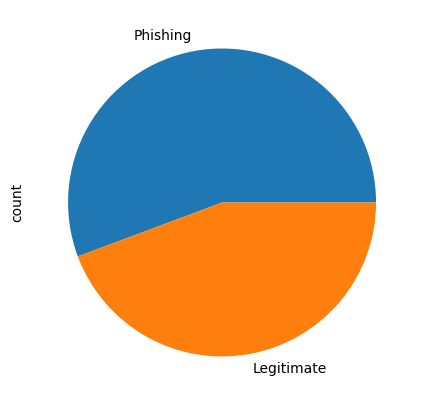

In [95]:
vc = duplicates_df.Phishing.value_counts()
vc = vc.rename(index={1: 'Phishing', -1: 'Legitimate'})
vc.plot.pie()

In [96]:
duplicates_value_counts = full_value_counts(duplicates_df.Phishing)

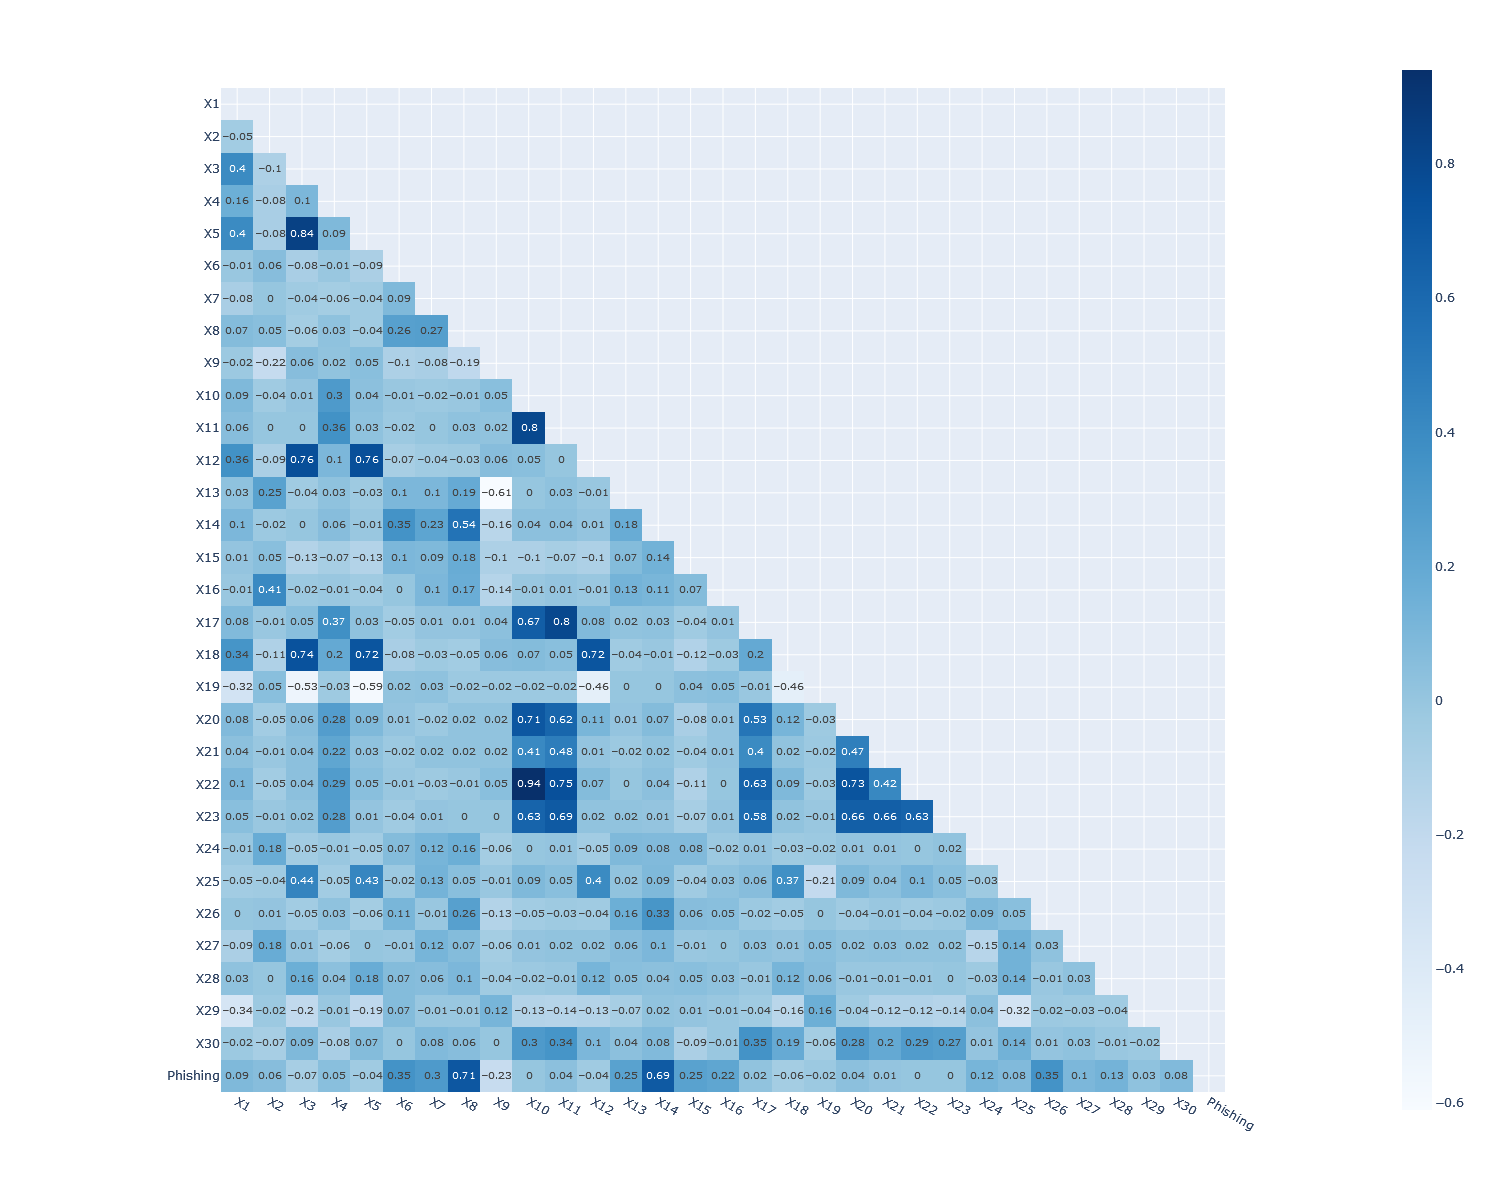

In [97]:
df_corr = duplicates_df.corr().round(2)  
mask = np.zeros_like(df_corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
df_corr_viz = df_corr.mask(mask)
fig = px.imshow(df_corr_viz, text_auto=True, width=1200, height=1200, color_continuous_scale='Blues')
fig.show()

<Axes: >

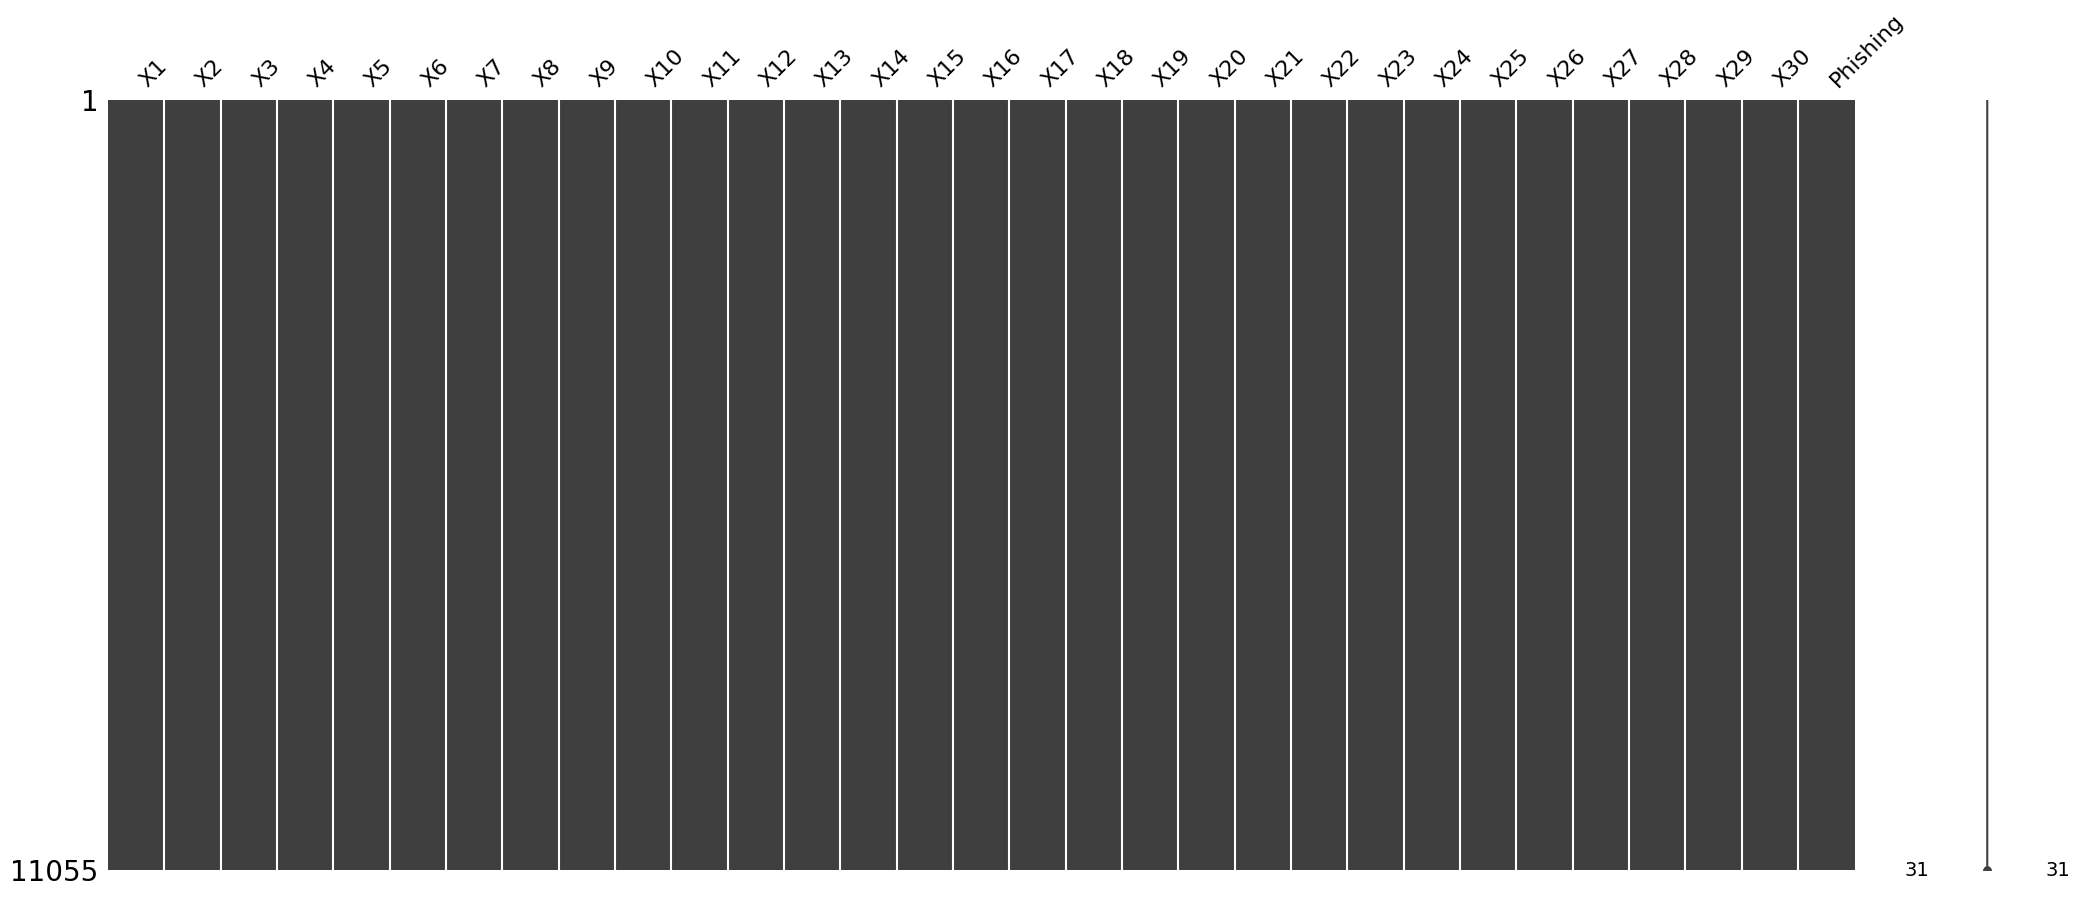

In [98]:
msno.matrix(duplicates_df)

## STEP 3: Data pre-processing

### Duplicates removal

Even though the dataset is already fairly balanced (56% phishing VS 44% legitimate), duplicate removal makes it even more so (52% phishing VS 48% legitimate), at the expenses of the reduction of 3327 phishing and 1879 legitimate duplicate rows.

Since the duplicate removal involves nominal features it is correct and it provides us with a reasonable benefit pertaining the data balance.

In [99]:
if DROP_DUPLICATES:
    df = duplicates_df.drop_duplicates()
    value_counts = full_value_counts(df.Phishing)
    display(value_counts)
    vc = df.Phishing.value_counts()
    vc = vc.rename(index={1: 'Phishing', -1: 'Legitimate'})
    vc.plot.pie()
    display((duplicates_value_counts - value_counts)['count'])
else:
    df = duplicates_df

## Step 4: Processing

In the following code snippets **5 different classifiers** performance are evaluated:
- Decision Tree
- K-Nearest Neighbors
- Linear Support Vector Classification
- Random Forest
- Logistic Regression

The performance of the model is evaluated using 10-fold stratified cross-validation.

Moreover, depending on the initial configuration, one of the following **feature selection** strategies is applied: 
  - Simple Variance Threshold
  - Linear SVC with L1 norm penalty

In [100]:
data = df[[col for col in list(df.columns) if col != 'Phishing']].to_numpy()
target = df.Phishing.to_numpy()

dt = DecisionTreeClassifier()
kn = KNeighborsClassifier()
svc = LinearSVC(max_iter=6000, dual='auto')
rf = RandomForestClassifier()
lr = LogisticRegression()
dc = DummyClassifier(strategy='uniform')
classifiers = (
    ('Decision Tree', 'DT', dt),
    ('K-Nearest Neighbors', 'KN', kn),
    ('Linear Support Vector Classification', 'SVC', svc),
    ('Random Forest', 'RF', rf),
    ('Logistic Regression', 'LR', lr),
    ('Dummy Classifier', 'DC', dc),
)

def select_features(X, y):
    if FEATURE_SELECTION == 'LinearSVC':
        lsvc = LinearSVC(C=0.001, penalty='l1', dual=False).fit(X, y)
        model = SelectFromModel(lsvc, prefit=True)
        X_new = model.transform(X)
    else:
        model = VarianceThreshold(0.4)  # threshold=(.8 * (1 - .8)) RESTORE ME
        X_new = model.fit_transform(X)
    print('New X shape:', X_new.shape)
    joblib.dump(model, 'fselect.joblib')
    print(type(X_new))
    print(len(X_new[0]))
    # Somehow I should be able to determine the removed columns...
    display(np.where(np.all(model.inverse_transform(X_new) == 0, axis=0))[0])
    return X_new

reduced_data = select_features(data, target)

New X shape: (11055, 26)
<class 'numpy.ndarray'>
26


array([18, 20, 22, 28], dtype=int64)

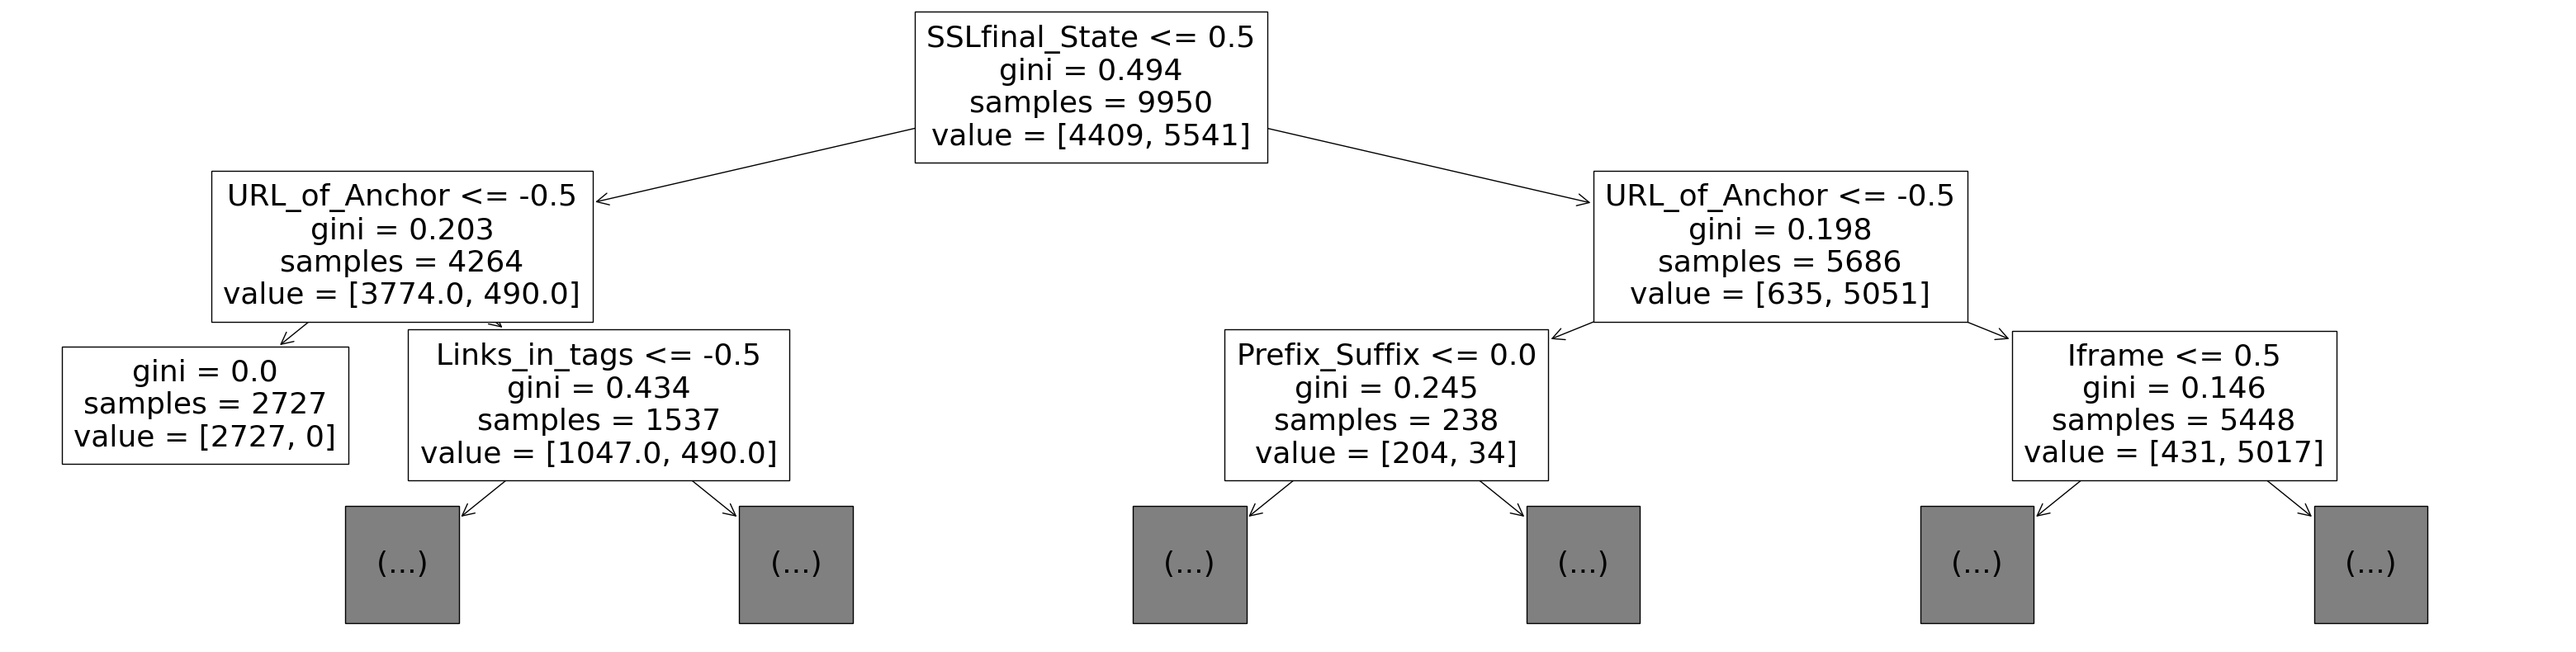

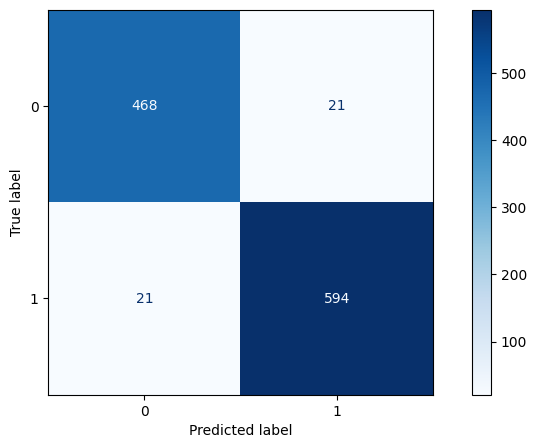

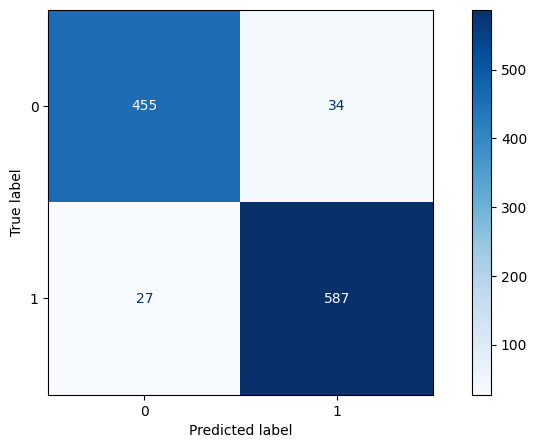

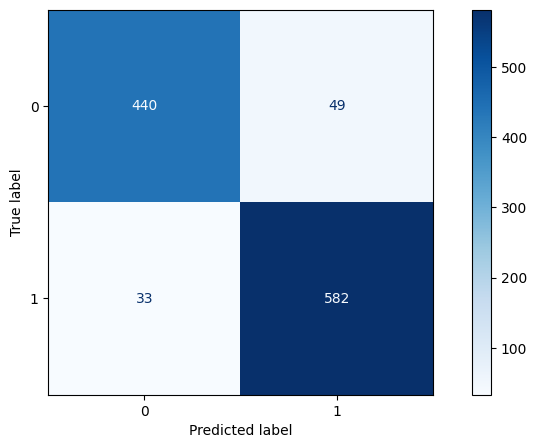

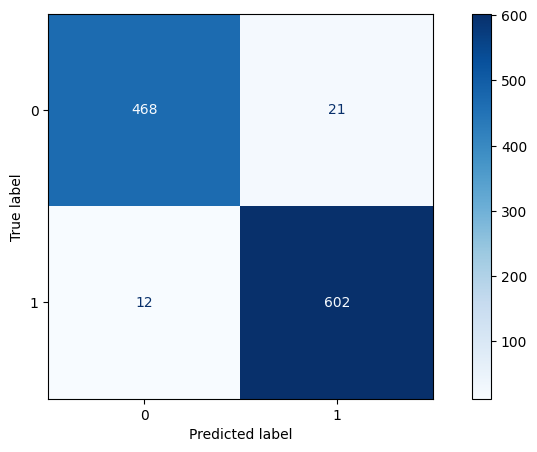

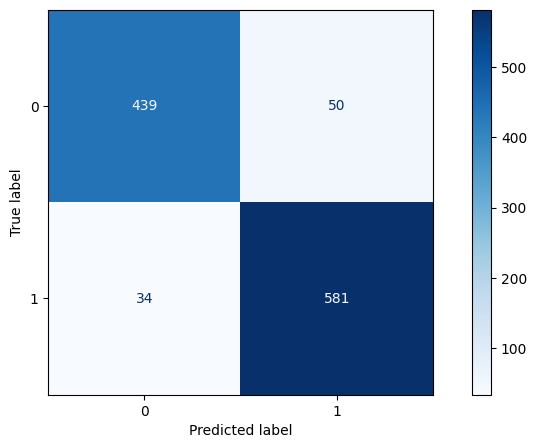

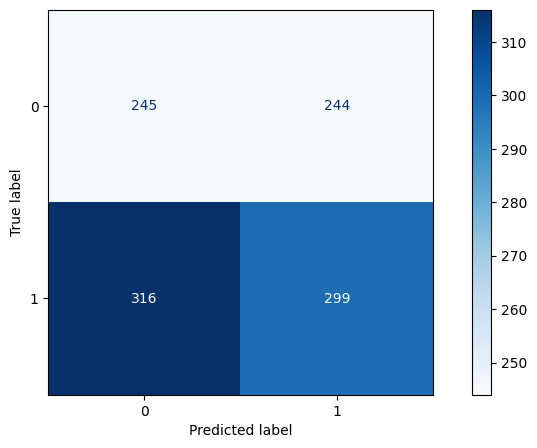

New X shape: (11055, 26)
<class 'numpy.ndarray'>
26


array([18, 20, 22, 28], dtype=int64)

,DT,KN,SVC,RF,LR
fit_time,"[0.010114431381225586, 0.018166780471801758, 0...","[0.0, 0.0, 0.0, 0.0020148754119873047, 0.0, 0....","[0.09931659698486328, 0.08023190498352051, 0.0...","[0.5385928153991699, 0.4849076271057129, 0.470...","[0.031232357025146484, 0.021682262420654297, 0..."
score_time,"[0.01565384864807129, 0.0, 0.01566886901855468...","[0.26819610595703125, 0.2660365104675293, 0.28...","[0.007969856262207031, 0.015622377395629883, 0...","[0.01770329475402832, 0.015631675720214844, 0....","[0.0, 0.015602827072143555, 0.0156254768371582..."
test_accuracy,"[0.9593128390596745, 0.9656419529837251, 0.957...","[0.933996383363472, 0.9547920433996383, 0.9339...","[0.918625678119349, 0.930379746835443, 0.91952...","[0.9656419529837251, 0.9719710669077758, 0.962...","[0.9213381555153707, 0.9276672694394213, 0.916..."
test_precision,"[0.9642276422764228, 0.9661290322580646, 0.949...","[0.938610662358643, 0.952076677316294, 0.93301...","[0.9187898089171974, 0.9178294573643411, 0.909...","[0.9646302250803859, 0.968, 0.9541864139020537...","[0.9232, 0.9161490683229814, 0.909375, 0.92675..."
test_recall,"[0.9626623376623377, 0.9724025974025974, 0.975...","[0.9431818181818182, 0.9675324675324676, 0.949...","[0.9366883116883117, 0.961038961038961, 0.9496...","[0.974025974025974, 0.9821428571428571, 0.9805...","[0.9366883116883117, 0.9577922077922078, 0.944..."
test_f1,"[0.9634443541835905, 0.9692556634304207, 0.962...","[0.9408906882591093, 0.9597423510466989, 0.941...","[0.927652733118971, 0.9389373513084853, 0.9293...","[0.9693053311793215, 0.9750201450443191, 0.967...","[0.9298952457695407, 0.9365079365079365, 0.926..."


,DT,KN,SVC,RF,LR
fit_time,0.017439,0.000201,0.086764,0.514245,0.036988
score_time,0.004695,0.280597,0.004864,0.018203,0.005130
test_accuracy,0.961919,0.941746,0.924739,0.969788,0.924377
test_precision,0.966294,0.942609,0.921063,0.966416,0.921549
test_recall,0.965405,0.953545,0.946076,0.979860,0.944778
test_f1,0.965801,0.948003,0.933362,0.973075,0.932978


CPU times: total: 14.3 s
Wall time: 22.1 s


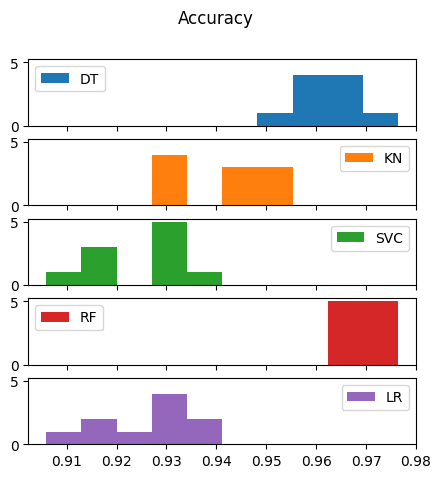

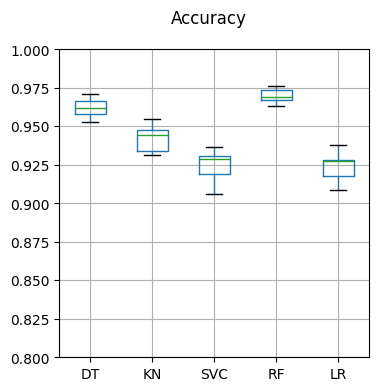

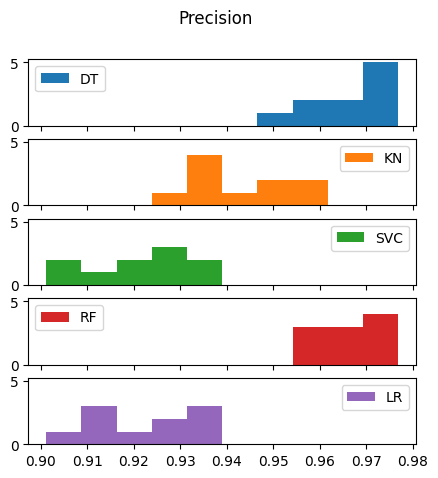

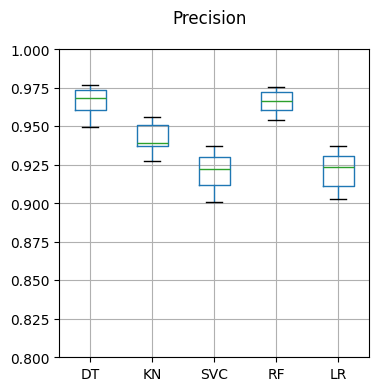

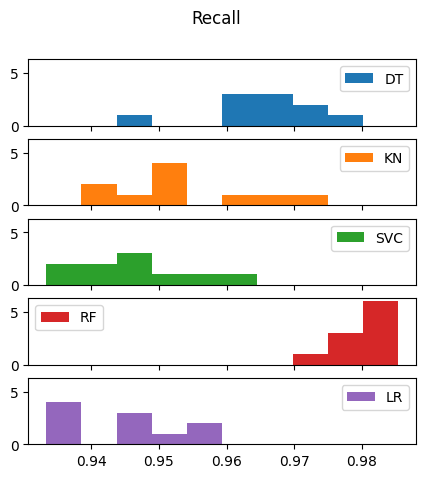

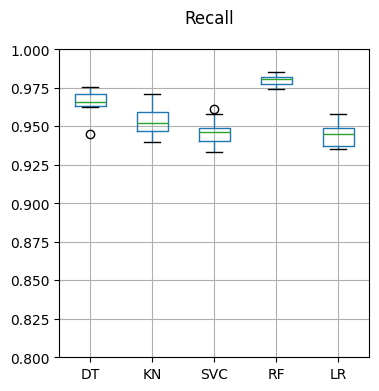

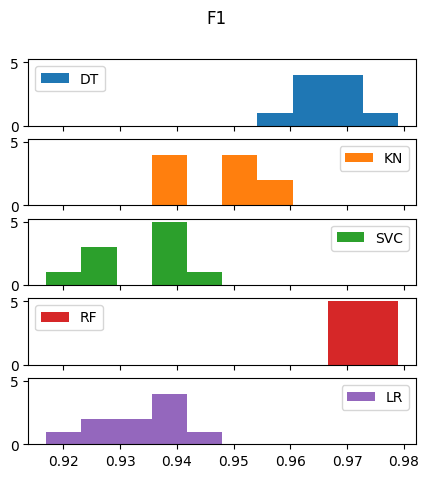

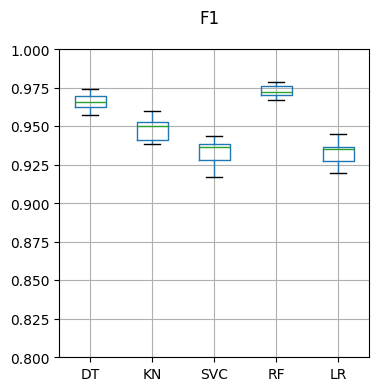

In [101]:
%%time

def extract(df, score):
    cca = df.loc[score].to_frame().transpose()
    cca = cca.explode([c for c in cca.columns])
    for c in cca.columns:
        cca[c] = cca[c].astype(float)
    return cca

def evaluate_classifiers(classifiers, reduced_data):
    skf = StratifiedKFold(n_splits=10, shuffle=True)
    for name, short_name, clf in classifiers:
        list_df = []
        list_cm = []
        list_accuracy = []
        
        for train, val in skf.split(reduced_data, target):
            # fit and predict using classifier
            X_tr = reduced_data[train]
            y_tr = target[train]
            X_val = reduced_data[val]
            y_val = target[val]
            clf.fit(X_tr,y_tr)
            y_pred = clf.predict(X_val)
            # compute classification report
            cr = classification_report(y_val, y_pred, output_dict = True)
            # store accuracy
            list_accuracy.append(cr['accuracy'])
            # store per-class metrics as a dataframe
            df = pd.DataFrame({k: v for k, v in cr.items() if k != 'accuracy'})
            list_df.append(df)
            # store confusion matrices as a dataframe
            cm = confusion_matrix(y_val, y_pred)
            list_cm.append(pd.DataFrame(cm))
            
        # compute average per-class metrics    
        df_concat = pd.concat(list_df)
        grouped_by_row_index = df_concat.groupby(df_concat.index)
        df_avg = grouped_by_row_index.mean()
    
        # compute average confusion matrix
        cm_concat = pd.concat(list_cm)
        grouped_by_row_index = cm_concat.groupby(cm_concat.index)
        cm_avg = grouped_by_row_index.mean().map(int)
        cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm_avg.to_numpy())
        
        # compute average accuracy
        acc_avg = np.mean(list_accuracy)
        display(HTML(f'<h3>{name}</h3>'))
        #display(df_avg)
        display(HTML(f'<strong>Average accuracy</strong> = {acc_avg}'))
        if short_name == 'DT':
            old_figsize = plt.rcParams["figure.figsize"]
            plt.rcParams["figure.figsize"] = (40, 10)
            sklearn.tree.plot_tree(clf, max_depth=2, feature_names=raw_df.columns)
            plt.rcParams["figure.figsize"] = old_figsize
        elif 'short_name' == 'RF':
            print("Trees =", len(clf.estimators_), type(clf.estimators_))
            plt.rcParams["figure.figsize"] = (40, 10)
            for i, e in enumerate(clf.estimators_[:5]):
                print("Tree", i)
                old_figsize = plt.rcParams["figure.figsize"]
                sklearn.tree.plot_tree(e, max_depth=2, feature_names=raw_df.columns)
                plt.show()
            plt.rcParams["figure.figsize"] = old_figsize
        cm_disp.plot(cmap='Blues')
        plt.show()
    skf_for_comp = StratifiedKFold(n_splits=10, shuffle=True, random_state=19820116)
    reduced_data = select_features(data, target)
    metrics = pd.DataFrame({
        short_name:
            #cross_val_score(clf, reduced_data, target, cv=skf_for_comp, scoring='accuracy'),
            cross_validate(clf, reduced_data, target, cv=skf_for_comp, scoring=('accuracy', 'precision', 'recall', 'f1')) for name, short_name, clf in classifiers
    })
    metrics_without_dc = metrics[["DT", "KN", "SVC", "RF", "LR"]]
    #print(metrics_without_dc.to_json())
    display(metrics_without_dc)
    metrics = {}
    for metric_name in ('test_accuracy', 'test_precision', 'test_recall', 'test_f1'):
        title = metric_name.split('_')[1].title()
        metric = extract(metrics_without_dc, metric_name)
        metric.plot(kind='hist', subplots=True, sharex=True, sharey=True, title=title, figsize=(5, 5), ylabel='')
        fig = plt.figure(figsize=(4,4))
        fig.suptitle(title, fontsize=12)
        ax = metric.boxplot(return_type='axes')
        ax.set_ylim(0.8, 1)
        fig.canvas.draw()
        metrics[metric_name] = metric
    avg_metrics = metrics_without_dc.map(lambda x: sum(x) / len(x))
    return metrics, avg_metrics

metrics, avg_metrics = evaluate_classifiers(classifiers, reduced_data)
display(avg_metrics)

In [102]:
def create_row(long_1, long_2, short_1, short_2):
    row = [long_1, long_2]
    for metric_name in ('test_accuracy', 'test_precision', 'test_recall', 'test_f1'):
        metric = metrics[metric_name]
        row.append(wilcoxon(metric[short_1], metric[short_2]).pvalue)
    return row
    
tests = []
#tests += [('Dummy', name, wilcoxon(metric['DC'], metric[short_name]).pvalue) for name, short_name, clf in classifiers if short_name != 'DC']
tests += [create_row('Linear Support Vector Classification', 'Logistic Regression', 'SVC', 'LR')]
tests += [create_row('Linear Support Vector Classification', 'Decision Tree', 'SVC', 'DT')]
tests += [create_row('Decision Tree', 'K-Nearest Neighbors', 'DT', 'KN')]
tests += [create_row('Random Forest', 'Decision tree', 'RF', 'DT')]
tests += [create_row('Random Forest', 'K-Nearest Neighbors', 'RF', 'KN')]
tests += [create_row('Random Forest', 'Linear Support Vector Classification', 'RF', 'SVC')]
tests += [create_row('Random Forest', 'Logistic Regression', 'RF', 'LR')]
null_test = pd.DataFrame(tests, columns=('Classifier 1', 'Classifier 2', 'Accuracy p-value', 'Precision p-value', 'Recall p-value', 'F1 p-value'))
display(HTML(f'<h3>Null Hypothesis Testing</h3>'))
display(null_test)

C:\Users\rnd\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_morestats.py:4088: UserWarning:

Exact p-value calculation does not work if there are zeros. Switching to normal approximation.

C:\Users\rnd\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_morestats.py:4102: UserWarning:

Sample size too small for normal approximation.



,Classifier 1,Classifier 2,Accuracy p-value,Precision p-value,Recall p-value,F1 p-value
0,Linear Support Vector Classification,Logistic Regression,0.695312,0.695312,0.232508,0.492188
1,Linear Support Vector Classification,Decision Tree,0.001953,0.001953,0.003906,0.001953
2,Decision Tree,K-Nearest Neighbors,0.001953,0.001953,0.013672,0.001953
3,Random Forest,Decision tree,0.001953,0.556641,0.001953,0.001953
4,Random Forest,K-Nearest Neighbors,0.001953,0.001953,0.001953,0.001953
5,Random Forest,Linear Support Vector Classification,0.001953,0.001953,0.001953,0.001953
6,Random Forest,Logistic Regression,0.001953,0.001953,0.001953,0.001953


### Improving the classifiers

What dataset should I use to determine the hyperparameters that deliver the best classifier performances? An hint comes from this article: [Nested versus non-nested cross-validation](https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html#sphx-glr-auto-examples-model-selection-plot-nested-cross-validation-iris-py). The basic idea is that non-nested cross-validation uses the same data both to tune the model parameters and to determine the model performance, which can lead to overfitting. Nested cross-validation, instead, uses a series of train/validation/test set splits.

In [103]:
skf_for_optimization = StratifiedKFold(n_splits=10, shuffle=True, random_state=19810814)

#### Random Forest

In [104]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [105]:
%%time

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy', 'log_loss'],
}
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=skf_for_optimization, n_jobs=-1, verbose=2)
grid_search.fit(reduced_data, target)
grid_search.best_params_

Fitting 10 folds for each of 81 candidates, totalling 810 fits
CPU times: total: 52.1 s
Wall time: 1min 46s


{'criterion': 'log_loss',
 'max_depth': 20,
 'min_samples_split': 2,
 'n_estimators': 100}

In [106]:
optimized_rf = RandomForestClassifier(**grid_search.best_params_)

#### Decision Tree

In [107]:
dt.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': None,
 'splitter': 'best'}

In [108]:
%%time

param_grid = {
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy', 'log_loss'],
}
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=skf_for_optimization, n_jobs=-1, verbose=2)
grid_search.fit(reduced_data, target)
grid_search.best_params_

Fitting 10 folds for each of 27 candidates, totalling 270 fits
CPU times: total: 156 ms
Wall time: 1.19 s


{'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 2}

In [109]:
optimized_dt = DecisionTreeClassifier(**grid_search.best_params_)

#### K-Nearest Neighbors

In [110]:
kn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [111]:
%%time

param_grid = {
    'n_neighbors': [2, 5, 10],
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3],
}
grid_search = GridSearchCV(estimator=kn, param_grid=param_grid, cv=skf_for_optimization, n_jobs=-1, verbose=2)
grid_search.fit(reduced_data, target)
grid_search.best_params_

Fitting 10 folds for each of 30 candidates, totalling 300 fits
CPU times: total: 1.36 s
Wall time: 3min 18s


{'n_neighbors': 10, 'p': 1, 'weights': 'distance'}

In [112]:
optimized_kn = KNeighborsClassifier(**grid_search.best_params_)

#### Linear Support Vector Classification

In [113]:
svc.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': 'auto',
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 6000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}

In [114]:
%%time

param_grid =  [
    {
        'penalty': ['l1'],
        'loss': ['squared_hinge'],
        'C': [0.1, 1, 10, 100],
        'dual': ['auto']
    },
    {
        'penalty': ['l2'],
        'loss': ['hinge', 'squared_hinge'],
        'C': [0.1, 1, 10, 100],
        'dual': ['auto']
    }
]
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=skf_for_optimization, n_jobs=-1, verbose=2)
grid_search.fit(reduced_data, target)
grid_search.best_params_

Fitting 10 folds for each of 12 candidates, totalling 120 fits
CPU times: total: 359 ms
Wall time: 22.9 s


{'C': 0.1, 'dual': 'auto', 'loss': 'squared_hinge', 'penalty': 'l2'}

In [115]:
optimized_svc = LinearSVC(**grid_search.best_params_)

#### Logistic Regression

In [116]:
lr.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [117]:
%%time

param_grid = [
    {
        'penalty': ['l2', None],
        'solver': ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag'],
        'max_iter': [50, 100]
    },
    {
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear'],
        'max_iter': [50, 100]
    },
    {
        'penalty': ['l1', 'l2', None],
        'solver': ['saga'],
        'max_iter': [50, 100]
    },
    {
        'penalty': ['elasticnet'],
        'solver': ['saga'],
        'l1_ratio': [0.2, 0.5, 0.8],
        'max_iter': [50, 100]
    }
]
grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, cv=skf_for_optimization, n_jobs=-1, verbose=2)
grid_search.fit(reduced_data, target)
grid_search.best_params_

Fitting 10 folds for each of 32 candidates, totalling 320 fits
CPU times: total: 484 ms
Wall time: 9.21 s


{'max_iter': 50, 'penalty': None, 'solver': 'newton-cg'}

In [118]:
optimized_lr = LogisticRegression(**grid_search.best_params_)

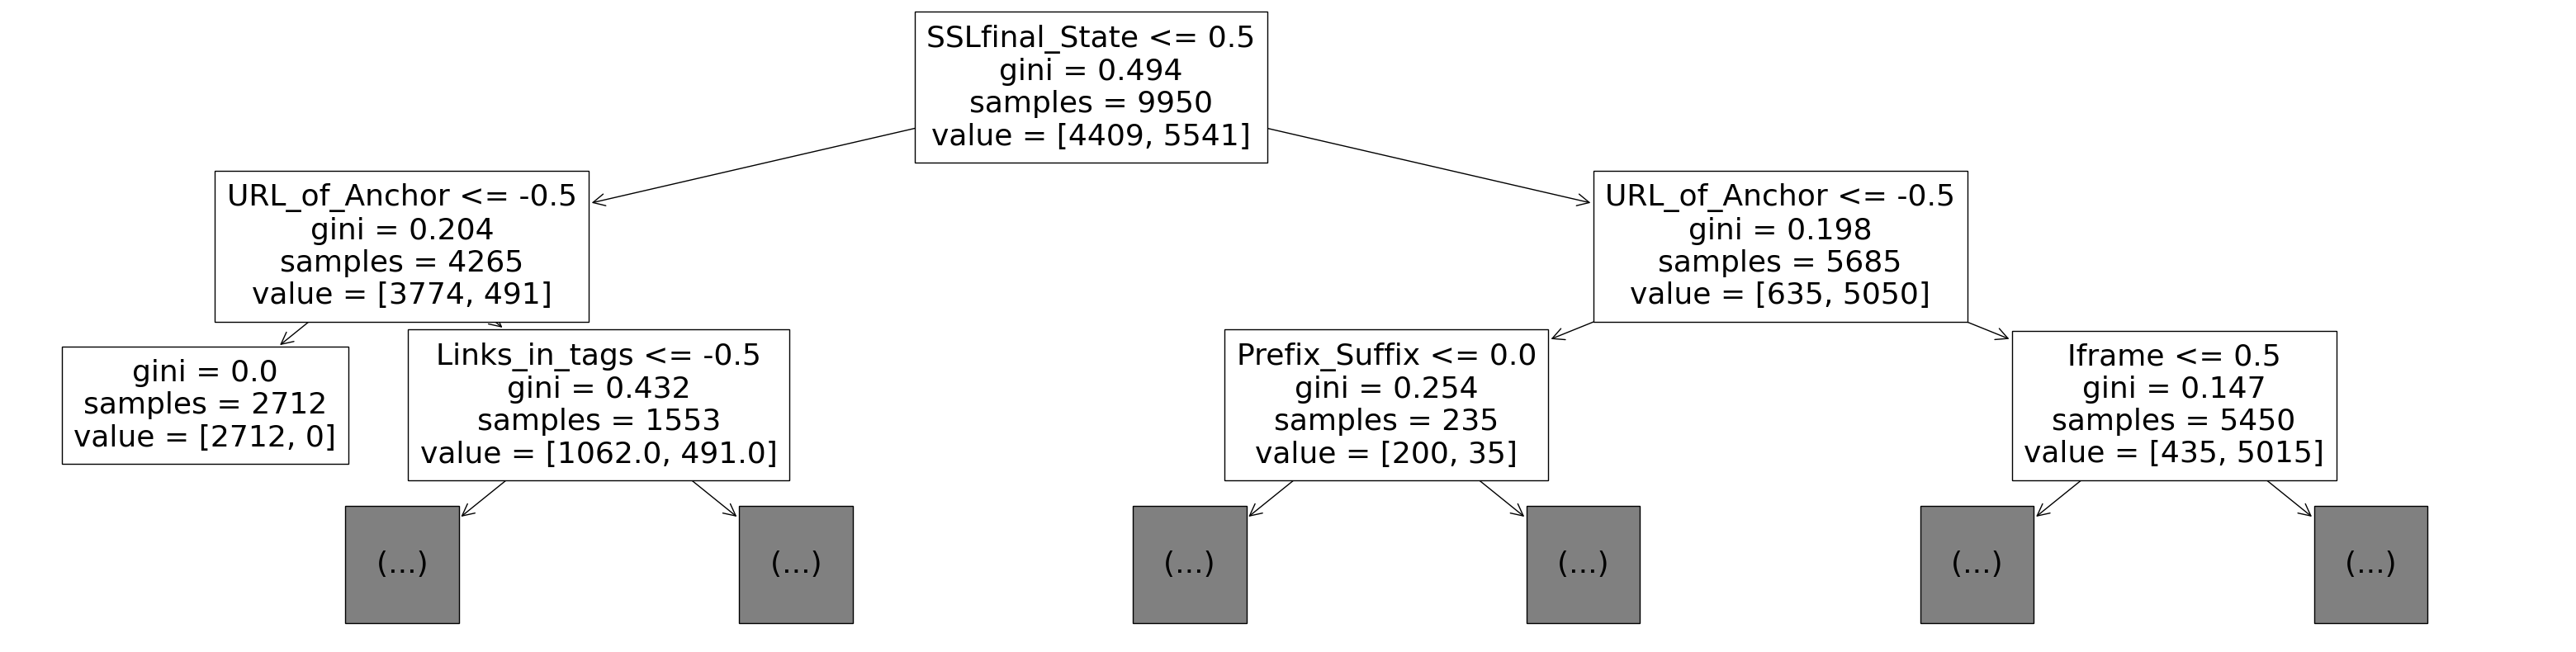

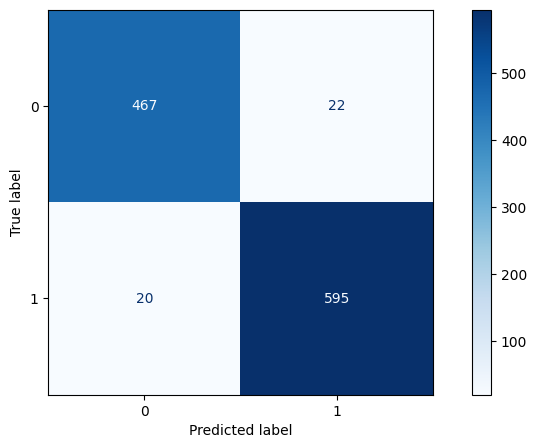

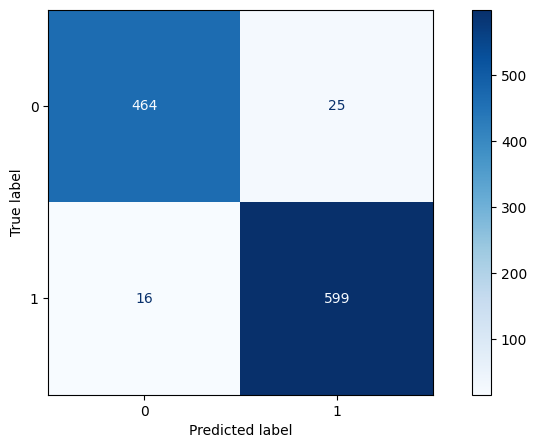

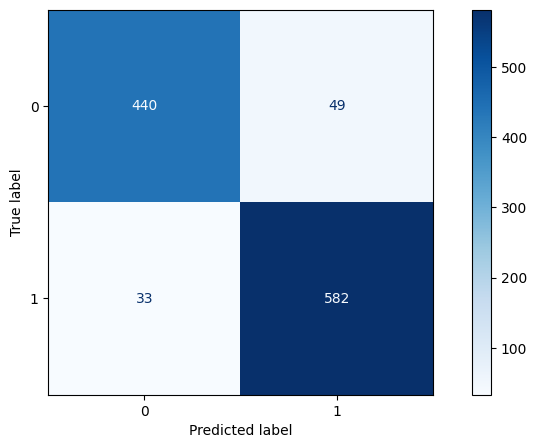

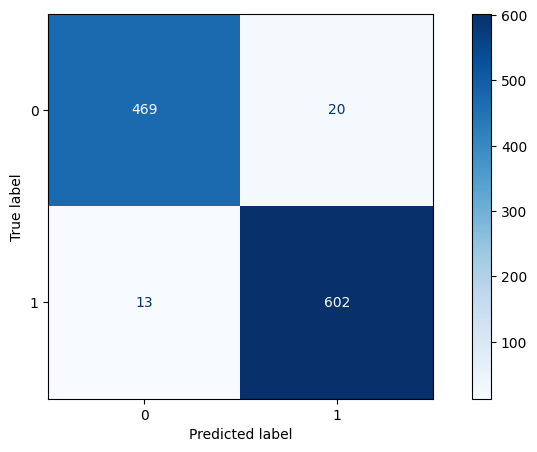

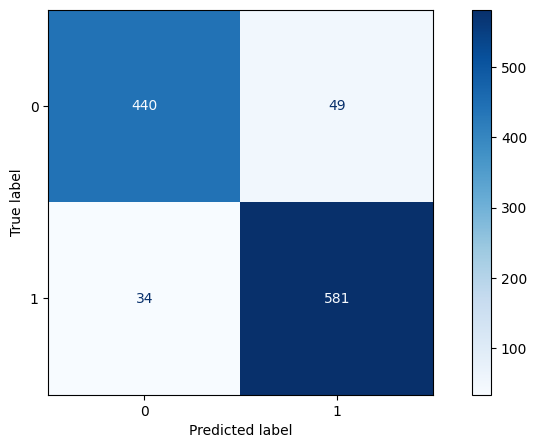

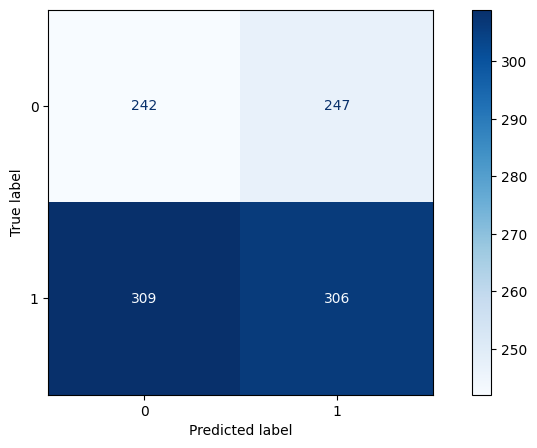

New X shape: (11055, 26)
<class 'numpy.ndarray'>
26


array([18, 20, 22, 28], dtype=int64)

,DT,KN,SVC,RF,LR
fit_time,"[0.015601396560668945, 0.01563286781311035, 0....","[0.015630245208740234, 0.0, 0.0156104564666748...","[0.031247377395629883, 0.0785822868347168, 0.0...","[0.5186474323272705, 0.5342059135437012, 0.545...","[0.05295276641845703, 0.06294846534729004, 0.0..."
score_time,"[0.0, 0.0, 0.0, 0.01338958740234375, 0.0050001...","[0.23581218719482422, 0.2342667579650879, 0.26...","[0.015625953674316406, 0.0, 0.0155973434448242...","[0.03128695487976074, 0.03127455711364746, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.01564764976501465, 0.0,..."
test_accuracy,"[0.9593128390596745, 0.9683544303797469, 0.952...","[0.9593128390596745, 0.9665461121157324, 0.952...","[0.918625678119349, 0.9321880650994575, 0.9204...","[0.9665461121157324, 0.9719710669077758, 0.963...","[0.9204339963833634, 0.9276672694394213, 0.916..."
test_precision,"[0.967266775777414, 0.9662921348314607, 0.9433...","[0.9627228525121556, 0.9602543720190779, 0.948...","[0.9187898089171974, 0.9193798449612403, 0.911...","[0.9676898222940227, 0.968, 0.9556962025316456...","[0.9230769230769231, 0.9161490683229814, 0.909..."
test_recall,"[0.9594155844155844, 0.9772727272727273, 0.972...","[0.9642857142857143, 0.9805194805194806, 0.965...","[0.9366883116883117, 0.9626623376623377, 0.949...","[0.9724025974025974, 0.9821428571428571, 0.980...","[0.935064935064935, 0.9577922077922078, 0.9448..."
test_f1,"[0.9633251833740831, 0.9717514124293786, 0.957...","[0.9635036496350365, 0.970281124497992, 0.9573...","[0.927652733118971, 0.9405233941316415, 0.9300...","[0.9700404858299595, 0.9750201450443191, 0.967...","[0.9290322580645162, 0.9365079365079365, 0.926..."


,DT,KN,SVC,RF,LR
fit_time,-0.001633,0.008187,-0.018808,0.005588,0.025413
score_time,-0.000066,-0.020591,0.002213,0.002271,-0.000500
test_accuracy,-0.000543,0.020535,0.000452,0.000452,-0.000090
test_precision,-0.001686,0.018864,0.000322,0.000319,0.000126
test_recall,0.000811,0.017706,0.000487,0.000487,-0.000325
test_f1,-0.000442,0.018313,0.000402,0.000403,-0.000096


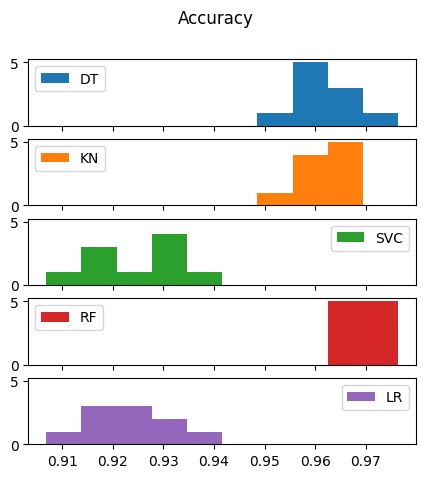

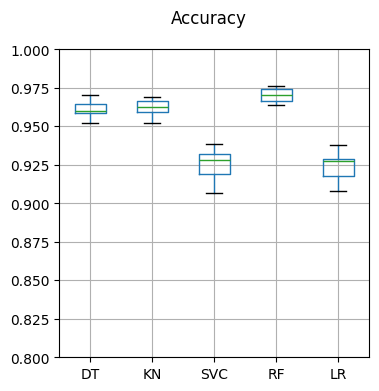

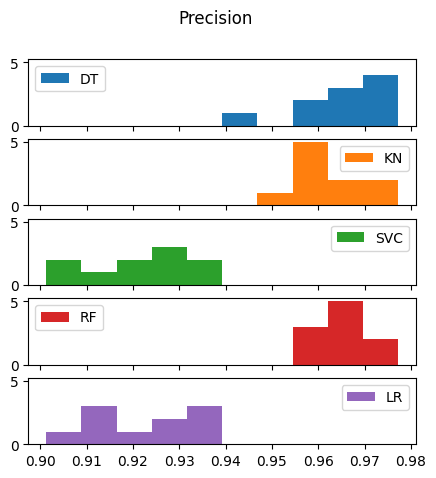

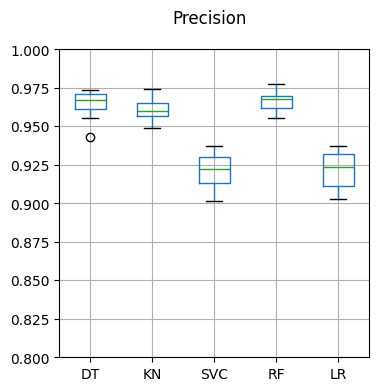

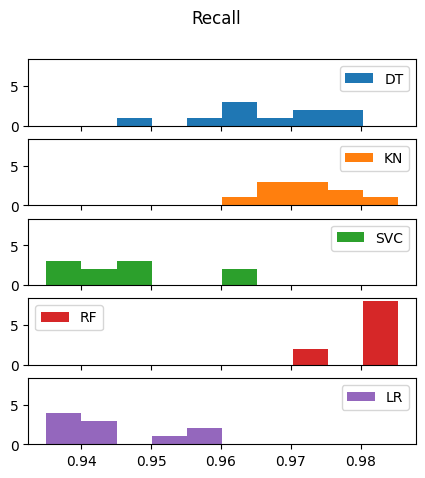

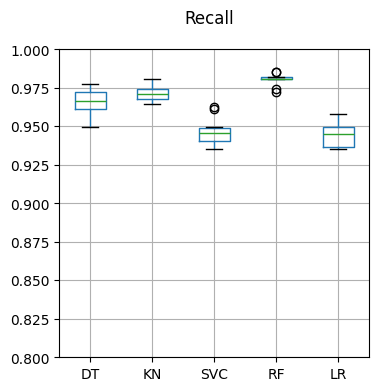

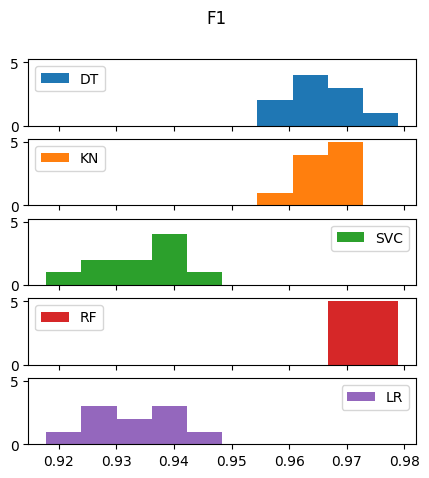

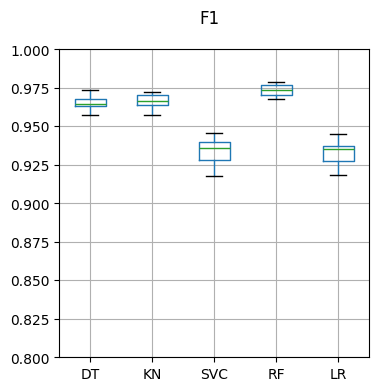

In [119]:
classifiers = (
    ('Decision Tree', 'DT', optimized_dt),
    ('K-Nearest Neighbors', 'KN', optimized_kn),
    ('Linear Support Vector Classification', 'SVC', optimized_svc),
    ('Random Forest', 'RF', optimized_rf),
    ('Logistic Regression', 'LR', optimized_lr),
    ('Dummy Classifier', 'DC', DummyClassifier(strategy='uniform')),
)

optimized_metrics, optimized_avg_metrics = evaluate_classifiers(classifiers, reduced_data)
display(optimized_avg_metrics - avg_metrics)

In [120]:
def create_opt_row(long_1, long_2, short_1, short_2):
    row = [long_1, long_2]
    for metric_name in ('test_accuracy', 'test_precision', 'test_recall', 'test_f1'):
        metric = optimized_metrics[metric_name]
        row.append(wilcoxon(metric[short_1], metric[short_2]).pvalue)
    return row

tests = []
#tests += [('Dummy', name, wilcoxon(metric['DC'], metric[short_name]).pvalue) for name, short_name, clf in classifiers if short_name != 'DC']
tests += [create_opt_row('Linear Support Vector Classification', 'Logistic Regression', 'SVC', 'LR')]
tests += [create_opt_row('Linear Support Vector Classification', 'Decision Tree', 'SVC', 'DT')]
tests += [create_opt_row('Decision Tree', 'K-Nearest Neighbors', 'DT', 'KN')]
tests += [create_opt_row('Random Forest', 'Decision tree', 'RF', 'DT')]
tests += [create_opt_row('Random Forest', 'K-Nearest Neighbors', 'RF', 'KN')]
tests += [create_opt_row('Random Forest', 'Linear Support Vector Classification', 'RF', 'SVC')]
tests += [create_opt_row('Random Forest', 'Logistic Regression', 'RF', 'LR')]
null_test = pd.DataFrame(tests, columns=('Classifier 1', 'Classifier 2', 'Accuracy p-value', 'Precision p-value', 'Recall p-value', 'F1 p-value'))
display(HTML(f'<h3>Null Hypothesis Testing</h3>'))
display(null_test)

C:\Users\rnd\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_morestats.py:4088: UserWarning:

Exact p-value calculation does not work if there are zeros. Switching to normal approximation.

C:\Users\rnd\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_morestats.py:4102: UserWarning:

Sample size too small for normal approximation.



,Classifier 1,Classifier 2,Accuracy p-value,Precision p-value,Recall p-value,F1 p-value
0,Linear Support Vector Classification,Logistic Regression,0.375000,0.845703,0.108185,0.232422
1,Linear Support Vector Classification,Decision Tree,0.001953,0.001953,0.001953,0.001953
2,Decision Tree,K-Nearest Neighbors,0.399656,0.160156,0.028263,0.431641
3,Random Forest,Decision tree,0.001953,0.322266,0.001953,0.001953
4,Random Forest,K-Nearest Neighbors,0.001953,0.001953,0.001953,0.001953
5,Random Forest,Linear Support Vector Classification,0.001953,0.001953,0.001953,0.001953
6,Random Forest,Logistic Regression,0.001953,0.001953,0.001953,0.001953


## HIC SUNT LEONES

In [121]:
%%time

#skf_for_comp = StratifiedKFold(n_splits=10, shuffle=True, random_state=19820116)
#metrics_accuracy = pd.DataFrame({
#    "Original RF": cross_val_score(rf, reduced_data, target, cv=skf_for_comp, scoring='accuracy'),
#    "Optimized RF": cross_val_score(optimized_rf, reduced_data, target, cv=skf_for_comp, scoring='accuracy')
#})
#metrics_accuracy.hist(layout=(3,2), figsize=(5,5), sharex=True);
#display(metrics_accuracy)
#ax = metrics_accuracy.boxplot(figsize=(4,4), return_type='axes')
#ax.set_ylim(0.85, 1)
#plt.show()

CPU times: total: 0 ns
Wall time: 0 ns


In [122]:
%%time

#skf_for_comp = StratifiedKFold(n_splits=10, shuffle=True, random_state=19820116)
#metrics_accuracy = pd.DataFrame({
#    "Original DT": cross_val_score(dt, reduced_data, target, cv=skf_for_comp, scoring='accuracy'),
#    "Optimized DT": cross_val_score(optimized_dt, reduced_data, target, cv=skf_for_comp, scoring='accuracy')
#})
#metrics_accuracy.hist(layout=(3,2), figsize=(5,5), sharex=True);
#display(metrics_accuracy)
#ax = metrics_accuracy.boxplot(figsize=(4,4), return_type='axes')
#ax.set_ylim(0.85, 1)
#plt.show()

CPU times: total: 0 ns
Wall time: 0 ns


In [123]:
#tests = [('Original RF', 'Optimized RF', wilcoxon(metrics_accuracy['Original RF'], metrics_accuracy['Optimized RF']).pvalue)]
#null_test = pd.DataFrame(tests, columns=('Classifier 1', 'Classifier 2', 'p-value'))
#display(HTML('<h3>Null Hypothesis Testing</h3>'))
#display(null_test)

In [124]:
#acc_comp = pd.DataFrame([
#    ['DT', 0.925857, 0.966080, 0],
#    ['KN', 0.921212, 0.946541, 0],
#    ['SVC', 0.922071, 0.928630, 0],
#    ['RF', 0.946670, 0.973135, 0],
#    ['LR', 0.921040, 0.928177,0 ],
#], columns = ['Classifier', 'Without duplicates', 'With duplicates', 'Difference'])
#acc_comp['Difference'] = acc_comp['With duplicates'] - acc_comp['Without duplicates']
#acc_comp

### Storing the model to file

In order to use the model in real time applications we need to store and load it.

In [125]:
joblib.dump(rf, 'rf.joblib') 

['rf.joblib']

In [126]:
end_time = datetime.now()
print('Total execution time (valid for full notepad execution only):', end_time - start_time)

Total execution time (valid for full notepad execution only): 0:06:29.769958
